In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#import packages
import pandas as pd 
import os
import re
import numpy as np
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import itertools
import jieba
import time
import sys
import math
import warnings
import operator
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import Counter, defaultdict 
from torch.utils.data import Dataset,DataLoader
from tqdm import notebook
from urllib.request import urlopen
from bs4 import BeautifulSoup
from torch import optim
from queue import PriorityQueue
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
#install Pythonrouge for ROUGE score calculation
!pip install git+https://github.com/tagucci/pythonrouge.git

  Created wheel for pythonrouge: filename=pythonrouge-0.2-cp36-none-any.whl size=285402 sha256=e8a1edc9187390260f8ec2d408fa8b45be84586d543704a4432a2abbab347c40
  Stored in directory: /tmp/pip-ephem-wheel-cache-j089chl9/wheels/fd/ff/be/6716935d513fa8656ab185cb0aa70aed382b72dda42bf09c95
Successfully built pythonrouge


In [ ]:
#import Pythonrouge and install dependencies
from pythonrouge.pythonrouge import Pythonrouge
!apt-get install -y cpanminus
!cpanm --force XML::Parser

In [ ]:
#initialize Jieba for Chinese text tokenization
jieba.enable_paddle()

Installing paddle-tiny, please wait a minute......
Paddle enabled successfully......


In [ ]:
#save index 0 for unk, 1 for pad, 2 for sos, 3 for eos
global PAD_IDX, UNK_IDX, SOS_IDX, EOS_IDX
UNK_IDX = 0
PAD_IDX = 1
SOS_IDX = 2
EOS_IDX = 3

In [ ]:
#read in the data
f = open('/content/drive/My Drive/1011 project/data/LCSTS2.0/DATA/PART_II.txt', 'r')
data = ''
for x in f:
    data += x

In [ ]:
#parse in as the html format
soup = BeautifulSoup(data, 'html.parser')

In [ ]:
#validation set length
train_len = int(len(soup.findAll('summary')) * 0.1)
val_len = int(train_len * 0.1)

In [ ]:
train_summary = []
for item in soup.findAll('summary')[:train_len]:
    sentence = item.text
    sentence = re.sub(r'[^\w\s]', '', sentence) 
    # cut_sentence = jieba.cut(sentence, use_paddle = True)
    train_summary.append([char for char in sentence.strip()])

In [ ]:
train_text = []
for item in soup.findAll('short_text')[:train_len]:
    sentence = item.text
    sentence = re.sub(r'[^\w\s]', '', sentence) 
    # cut_sentence = jieba.cut(sentence, use_paddle = True)
    train_text.append([char for char in sentence.strip()])

In [ ]:
val_summary = []
for item in soup.findAll('summary')[train_len: train_len + val_len]:
    sentence = item.text
    sentence = re.sub(r'[^\w\s]', '', sentence) 
    # cut_sentence = jieba.cut(sentence, use_paddle = True)
    val_summary.append([char for char in sentence.strip()])

In [ ]:
val_text = []
for item in soup.findAll('short_text')[train_len: train_len + val_len]:
    sentence = item.text
    sentence = re.sub(r'[^\w\s]', '', sentence) 
    # cut_sentence = jieba.cut(sentence, use_paddle = True)
    val_text.append([char for char in sentence.strip()])

In [ ]:
cd drive/My Drive/1011 project

/content/drive/.shortcut-targets-by-id/1RluAp2PiiVCc35Zf02WlMXypdtkT_Wh3/1011 project


In [ ]:
data_dir = './data'

In [ ]:
torch.save(train_summary, os.path.join(data_dir, 'train_summary_full.pt'))
torch.save(train_text, os.path.join(data_dir, 'train_text_full.pt'))
torch.save(val_summary, os.path.join(data_dir, 'val_summary_full.pt'))
torch.save(val_text, os.path.join(data_dir, 'val_text_full.pt'))

In [ ]:
train_summary = torch.load(os.path.join(data_dir, 'train_summary_full.pt'))
train_text = torch.load(os.path.join(data_dir, 'train_text_full.pt'))
val_summary = torch.load(os.path.join(data_dir,'val_summary_full.pt'))
val_text = torch.load(os.path.join(data_dir,'val_text_full.pt'))

In [ ]:
#sentence length
train_summary_len = [len(item) for item in train_summary]
train_text_len = [len(item) for item in train_text]
print('max len for summary is: ', np.max(train_summary_len), ', ',
      'min len for summary is: ', np.min(train_summary_len), ', '
      'average len for summary is: {:.0f}'.format(np.mean(train_summary_len)))
print('max len for text is: ', np.max(train_text_len), ', ',
      'min len for text is : ', np.min(train_text_len), ', ',
      'average len for text is: {:.0f}'.format(np.mean(train_text_len)))

max len for summary is:  30 ,  min len for summary is:  3 , average len for summary is: 17
max len for text is:  130 ,  min len for text is :  50 ,  average len for text is: 93


In [ ]:
def build_vocab(data, max_vocab_size = 50000):

    token2id = dict()
    id2token = []
    combine = data
    tok2freq = defaultdict(int)
    
    for sentence in combine:
        for word in sentence:
            if word in token2id:
                tok2freq[word] += 1
            else:
                tok2freq[word] = 1
    tok_and_freqs = [(k, v) for k, v in tok2freq.items()]
    tok_and_freqs.sort(key = lambda x: x[1], reverse = True)
    token2id = {tok: idx + 4 for idx, (tok, _) in enumerate(tok_and_freqs[:max_vocab_size - 4])}
    token2id['UNK'] = UNK_IDX
    token2id['<SOS>'] = SOS_IDX
    token2id['<EOS>'] = EOS_IDX 
    token2id['<PAD>'] = PAD_IDX
    id2token = ['UNK', '<PAD>', '<SOS>', '<EOS>'] 
    id2token.extend([tok for idx, (tok, _) in enumerate(tok_and_freqs[:max_vocab_size - 4])])

    return (token2id, id2token)  

In [ ]:
def token2index(tokens_data):
    
    result = [[token2id['<SOS>']] + [token2id[word] if word in token2id else token2id['UNK'] for word in sentence] + [token2id['<EOS>']] for sentence in tokens_data]   
    
    return result

In [ ]:
global token2id
token2id, id2token = build_vocab(train_text + train_summary + val_text + val_summary)

In [ ]:
text_data_indices_train = token2index(train_text)
summary_data_indices_train = token2index(train_summary)
text_data_indices_val = token2index(val_text)
summary_data_indices_val = token2index(val_summary)

In [ ]:
def newsgroup_collate_func(batch):

    data_list = []
    len_data_list = []
    label_list = []
    len_label_lsit = []

    for datum in batch:
        len_data_list.append(datum[1])
        len_label_lsit.append(datum[3])

    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), pad_width = ((0, max_text_length - datum[1])), mode = "constant", constant_values = 1)
        data_list.append(padded_vec)
        padded_vec = np.pad(np.array(datum[2]), pad_width = ((0, max_summary_length - datum[3])), mode = "constant", constant_values = 1)
        label_list.append(padded_vec)

    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(len_data_list), torch.LongTensor(label_list), torch.LongTensor(len_label_lsit)]

In [ ]:
class NewsGroupDataset(Dataset):

    def __init__(self, data_list, target_list, max_summary_length, max_text_length):

        self.data_list = data_list
        self.target_list = target_list
        self.max_summary_length = max_summary_length
        self.max_text_length = max_text_length
        assert (len(self.data_list) == len(self.target_list))
        
    def __len__(self):

        return len(self.data_list)

    def __getitem__(self, key):

        token_data_idx = self.data_list[key][:self.max_text_length]
        token_label_idx = self.target_list[key][:self.max_summary_length]
        
        return [token_data_idx, len(token_data_idx), token_label_idx, len(token_label_idx)]

In [ ]:
max_text_length = int(np.quantile(train_text_len, 0.95))
max_summary_length = int(np.quantile(train_summary_len, 0.9999))

In [ ]:
train_dataset = NewsGroupDataset(text_data_indices_train, summary_data_indices_train, max_summary_length, max_text_length) 
val_dataset = NewsGroupDataset(text_data_indices_val, summary_data_indices_val, max_summary_length, max_text_length) 

In [ ]:
train_input = DataLoader(train_dataset, batch_size = 128, collate_fn = newsgroup_collate_func, shuffle = True, num_workers = 0)
val_input = DataLoader(val_dataset, batch_size = 128, collate_fn = newsgroup_collate_func, shuffle = True, num_workers = 0)

In [ ]:
class EncoderRNN(nn.Module):

    def __init__(self, input_size, hidden_size, numlayers):

        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size, padding_idx = PAD_IDX)
        self.gru = nn.GRU(
            hidden_size, hidden_size, num_layers = numlayers, batch_first = True
        )

    def forward(self, input, hidden = None):

        embedded = self.embedding(input)
        output, hidden = self.gru(embedded, hidden)

        return output, hidden

In [ ]:
class DecoderRNN(nn.Module):

    def __init__(self, output_size, hidden_size, numlayers):

        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(
            hidden_size, hidden_size, num_layers = numlayers, batch_first=True
        )
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 2)

    def forward(self, input, hidden, encoder_output = None, xs_len = None, context_vec = None):

        emb = self.embedding(input)
        rel = F.relu(emb)
        output, hidden = self.gru(rel, hidden)
        scores = self.softmax(self.out(output))

        return scores, hidden, None, None

In [ ]:
class Attention_Module(nn.Module):

    def __init__(self, hidden_dim, output_dim):

        super(Attention_Module, self).__init__()
        self.l1 = nn.Linear(hidden_dim, output_dim, bias=False)
        self.l2 = nn.Linear(hidden_dim + output_dim, output_dim, bias=False)

    def forward(self, hidden, encoder_outs, src_lens):

        x = self.l1(hidden)
        att_score = torch.bmm(encoder_outs, x.unsqueeze(-1)) 
        att_score = att_score.squeeze(-1)
        att_score = att_score.transpose(0, 1)
        
        seq_mask = self.sequence_mask(src_lens, 
                                      max_len = max(src_lens).item(), 
                                      device = hidden.device).transpose(0, 1)


        masked_att = seq_mask * att_score
        masked_att[masked_att == 0] = -1e10
        attn_scores = F.softmax(masked_att, dim = 0)
        x = (attn_scores.unsqueeze(2) * encoder_outs.transpose(0, 1)).sum(dim = 0)
        x = torch.tanh(self.l2(torch.cat((x, hidden), dim = 1)))

        return x, attn_scores

    def sequence_mask(self, sequence_length, max_len = None, device = torch.device('cuda')):

        if max_len is None:
            max_len = sequence_length.max().item()
        
        batch_size = sequence_length.size(0)
        seq_range = torch.arange(0, max_len).long()
        seq_range_expand = seq_range.unsqueeze(0).repeat([batch_size, 1])
        seq_range_expand = seq_range_expand.to(device)
        seq_length_expand = (sequence_length.unsqueeze(1)
                             .expand_as(seq_range_expand))
        
        return (seq_range_expand < seq_length_expand).float()

In [ ]:
class Decoder(nn.Module):

    def __init__(self, output_size, hidden_size):
        super(Decoder, self).__init__()

        self.output_size = output_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.memory_rnn = nn.GRUCell(2 * hidden_size, hidden_size, bias = True)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)
        self.encoder_attention_module = Attention_Module(self.hidden_size, self.hidden_size);
        
    def forward(self, input, memory, encoder_output = None, xs_len = None, context_vec = None):
        memory = memory.transpose(0, 1)
        emb = self.embedding(input)
        emb = F.relu(emb)
        emb = emb.transpose(0, 1)
        return_scores = torch.empty(emb.size(0), emb.size(1), self.output_size).to(input.device)
        
        if context_vec is None:
            context_vec = torch.zeros([emb.size(1), self.hidden_size]).to(emb.device)

        attn_wts_list = []

        for t in range(emb.size(0)):
            current_vec = emb[t]

            selected_memory = memory[:, -1, :]
            current_vec = torch.cat([current_vec, context_vec], dim = 1)

            mem_out = self.memory_rnn(current_vec, selected_memory)
            
            context_vec, attention0 = self.encoder_attention_module(mem_out, encoder_output, xs_len)
            scores = self.out(context_vec)
            attn_wts_list.append(attention0)

            scores = self.softmax(scores)
            return_scores[t] = scores

            memory = mem_out[:, None, :]
            
        return return_scores.transpose(0, 1).contiguous(), memory.transpose(0, 1), attn_wts_list, context_vec

In [ ]:
class seq2seq(nn.Module):
    def __init__(
        self,
        encoder,
        decoder,
        id2token,
        lr = 1e-3,
        use_cuda = True,
        clip = 0.1,
        longest_label = 15
    ):
        super(seq2seq, self).__init__()

        device = torch.device(
            "cuda" if (torch.cuda.is_available() and use_cuda) else "cpu"
        )
        self.device = device
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.criterion = nn.NLLLoss()
        self.optims = {
            "summarization": optim.SGD(self.parameters(), lr = lr, nesterov = True, momentum = 0.99)
        }
        self.clip = clip
        self.START = torch.LongTensor([SOS_IDX]).to(device)
        self.END_IDX = EOS_IDX
        self.id2token = id2token
        self.longest_label = longest_label

    def zero_grad(self):

        for optimizer in self.optims.values():
            optimizer.zero_grad()

    def update_params(self):

        if self.clip is not None:
            torch.nn.utils.clip_grad_norm_(self.encoder.parameters(), self.clip)
            torch.nn.utils.clip_grad_norm_(self.decoder.parameters(), self.clip)
        for optimizer in self.optims.values():
            optimizer.step()

    def get_rouge_score(self, val_loader):

        scores = []
        for batch in val_loader:
            prediction = self.eval_step(batch)
            scores.append(rouge_score(prediction, batch[2])) 
        
        return average_rouge_score(scores)

    def train_step(self, batch):

        xs, xs_len, ys = batch[0], batch[1], batch[2]

        if xs is None:
            return
        xs = xs.to(self.device)
        ys = ys.to(self.device)
        xs_len = xs_len.to(self.device)

        bsz = xs.size(0)
        starts = self.START.expand(bsz, 1)
        loss = 0
        self.zero_grad()
        self.encoder.train()
        self.decoder.train()
        encoder_output, encoder_hidden = self.encoder(xs)

        y_in = ys.narrow(1, 0, ys.size(1) - 1)
        decoder_input = torch.cat([starts, y_in], 1)

        decoder_output, decoder_hidden, _, _, = self.decoder(decoder_input,
                                                             encoder_hidden, 
                                                             encoder_output,
                                                             xs_len)


        scores = decoder_output.view(-1, decoder_output.size(-1))
        loss = self.criterion(scores, ys.view(-1))
        loss.backward()
        self.update_params()

        return loss.item()

    def eval_step(self, batch, return_attn = False):
        xs, xs_len = batch[0], batch[1]

        if xs is None:
            return

        xs = xs.to(self.device)
        xs_len = xs_len.to(self.device)

        bsz = xs.size(0)
        starts = self.START.expand(bsz, 1)  
        self.encoder.eval()
        self.decoder.eval()
        encoder_output, encoder_hidden = self.encoder(xs)

        predictions = []
        done = [False for _ in range(bsz)]
        total_done = 0
        decoder_input = starts
        decoder_hidden = encoder_hidden
        
        attn_wts_list = []
        self_attn_wts_list = []
        context_vec = None;

        for i in range(self.longest_label):

            decoder_output, decoder_hidden, attn_wts, context_vec = self.decoder(decoder_input,
                                                                                 decoder_hidden,
                                                                                 encoder_output, 
                                                                                 xs_len, 
                                                                                 context_vec)
            
            _, preds = decoder_output.max(2)
            predictions.append(preds)
            decoder_input = preds
            
            attn_wts_list.append(attn_wts)

            for b in range(bsz):
                if not done[b]:
                    if preds[b].item() == self.END_IDX:
                        done[b] = True
                        total_done += 1
            if total_done == bsz:
                break
        predictions = torch.cat(predictions, 1)
        
        if return_attn:
            return predictions, attn_wts_list
        return predictions


    def eval_step_beam_search(self, batch, topk = 2, beam_width = 2, return_attn = False):
        xs, xs_lens = batch[0], batch[1]

        if xs is None:
            return

        xs = xs.to(self.device)
        xs_lens = xs_lens.to(self.device)

        bsz = xs.size(0)
        starts = self.START.expand(bsz, 1) 
        self.encoder.eval()
        self.decoder.eval()
        encoder_outputs, encoder_hiddens = self.encoder(xs)

        predictions = []
        decoder_input = starts
        decoder_hiddens = encoder_hiddens
        
        attn_wts_lists = []
        self_attn_wts_lists = []

        for idx in range(bsz):
            context_vec = None
            attn_wts_list = []
            self_attn_wts_list = []
            decoder_hidden = decoder_hiddens[-1, idx, :].unsqueeze(0).unsqueeze(1)
            encoder_output = encoder_outputs[:, idx, :].unsqueeze(0)
            xs_len = xs_lens[idx].reshape(-1,)

            endnodes = []
            node = BeamSearchNode(decoder_hidden, None, decoder_input, 0, 1)
            nodes = PriorityQueue()
            nodes.put((-node.eval(), node))
            qsize = 1             
            
            while True:
                if qsize > 500: 
                    break

                score, n = nodes.get()
                decoder_input = n.wordid
                decoder_hidden = n.h

                if n.wordid.item() == EOS_IDX and n.prevNode != None:
                    endnodes.append((score, n))
                    if len(endnodes) >= self.longest_label:
                        break
                    else:
                        continue
                                        
                decoder_output, decoder_hidden, _, context_vec, = self.decoder(decoder_input,
                                                                               decoder_hidden,
                                                                               encoder_output, 
                                                                               xs_len, 
                                                                               context_vec)
                
                log_prob, indexes = torch.topk(decoder_output, beam_width)
                nextnodes = []

                for new_k in range(beam_width):
                    decoded_t = indexes[0][0][new_k].view(1, -1)
                    log_p = log_prob[0][0][new_k].item()

                    node = BeamSearchNode(decoder_hidden, n, decoded_t, n.logp + log_p, n.leng + 1)
                    score = -node.eval()
                    nextnodes.append((score, node))

                for i in range(len(nextnodes)):
                    score, nn = nextnodes[i]
                    nodes.put((score, nn))
                qsize += len(nextnodes) - 1

            if len(endnodes) == 0:
                endnodes = [nodes.get() for _ in range(topk)]

            utterances = []
            for score, n in sorted(endnodes, key = operator.itemgetter(0)):
                utterance = []
                utterance.append(n.wordid)
                while n.prevNode != None:
                    n = n.prevNode
                    utterance.append(n.wordid)

                utterance = utterance[::-1]
                utterances.append(utterance)

            predictions.append(utterances)
            attn_wts_lists.append(attn_wts_list)
            self_attn_wts_lists.append(self_attn_wts_list)
        
        return predictions

In [ ]:
class BeamSearchNode(object):
    def __init__(self, hiddenstate, previousNode, wordId, logProb, length):

        self.h = hiddenstate
        self.prevNode = previousNode
        self.wordid = wordId
        self.logp = logProb
        self.leng = length

    def eval(self, alpha = 1.0):
        reward = 0

        return self.logp / float(self.leng - 1 + 1e-6) + alpha * reward

In [ ]:
def rouge_score(summaries, references):

    summary_lst, reference_lst = [], []
    summaries = summaries.cpu().detach().numpy()
    references = references.cpu().detach().numpy()
    for summary in summaries:
        summary_lst.append([' '.join([str(idx) for idx in summary if idx not in [PAD_IDX, SOS_IDX, EOS_IDX]])])

    for reference in references:
        reference_lst.append([[' '.join([str(idx) for idx in reference if idx not in [PAD_IDX, SOS_IDX, EOS_IDX]])]])

    rouge = Pythonrouge(summary_file_exist = False,
                        summary = summary_lst, reference = reference_lst,
                        n_gram = 2, ROUGE_SU4 = True, ROUGE_L = True,
                        recall_only = True)
    score = rouge.calc_score()

    return score

def average_rouge_score(score_lst):

    keys = score_lst[0].keys()
    result = {}
    for key in keys:
        result[key] = np.mean([x[key] for x in score_lst])

    return result

In [ ]:
# Train and save models
def save_models(model, filename, path):

    if not os.path.exists(path):
        os.makedirs(path)
    torch.save(model, os.path.join(path, filename))

def train_model(data_input, model, model_name, num_epochs = 30):

    train_loss, val_rouges = [], []

    best_rouge = {'ROUGE-1': 0, 'ROUGE-2': 0, 'ROUGE-L': 0, 'ROUGE-SU4': 0}

    for epoch in range(num_epochs):

        start = time.time()
        running_loss = 0

        print('Epoch: [{}/{}]'.format(epoch + 1, num_epochs))
        
        for i, data in notebook.tqdm(enumerate(data_input), total = len(data_input)):  
            curr_loss = model.train_step(data)
            running_loss += curr_loss

        epoch_loss = running_loss / len(data_input) 
        
        print("epoch {} training loss = {}, time = {}".format(epoch + 1, epoch_loss,
                                                              time.time() - start))
        
        train_loss.append(epoch_loss)
        sys.stdout.flush()
        
        val_rouge = model.get_rouge_score(val_input)
        print('validation rouge: ')
        print(val_rouge)
        sys.stdout.flush()
        val_rouges.append(val_rouge)

        if all([val_rouge[key] > best_rouge[key] for key in val_rouge.keys()]):
            best_rouge = val_rouge
            save_models(model, model_name, model_dir)
            print('save new model')

        print('=' * 50)

    return train_loss, val_rouges

In [ ]:
vocab_size = len(id2token)
hidden_size = 128
numlayers = 1

In [ ]:
encoder = EncoderRNN(vocab_size, hidden_size, numlayers)
decoder_attn = Decoder(vocab_size, hidden_size)
decoder_noattn = DecoderRNN(vocab_size, hidden_size, numlayers)

In [ ]:
model_noattn = seq2seq(encoder, decoder_noattn, id2token, lr = 0.01)

In [ ]:
model_dir = './model'

In [ ]:
result_dir = './result'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

In [ ]:
training_loss_rnn, validation_rouges_rnn = train_model(train_input, model_noattn, 'rnn_seq2seq_noattn') 

Epoch: [1/30]



epoch 1 training loss = 4.376782341783484, time = 41.62109851837158
validation rouge: 
{'ROUGE-1': 0.03296042944785276, 'ROUGE-2': 0.003906319018404908, 'ROUGE-L': 0.03158748466257669, 'ROUGE-SU4': 0.00780319018404908}
save new model
Epoch: [2/30]



epoch 2 training loss = 3.7846801329362876, time = 40.98039746284485
validation rouge: 
{'ROUGE-1': 0.04239116564417178, 'ROUGE-2': 0.006712883435582821, 'ROUGE-L': 0.03969588957055215, 'ROUGE-SU4': 0.009559509202453987}
save new model
Epoch: [3/30]



epoch 3 training loss = 3.641657344089663, time = 41.54130148887634
validation rouge: 
{'ROUGE-1': 0.03848061349693251, 'ROUGE-2': 0.005527730061349694, 'ROUGE-L': 0.036641411042944785, 'ROUGE-SU4': 0.008732638036809817}
Epoch: [4/30]



epoch 4 training loss = 3.5469377334120824, time = 39.92081594467163
validation rouge: 
{'ROUGE-1': 0.0460278527607362, 'ROUGE-2': 0.007330920245398772, 'ROUGE-L': 0.040924417177914105, 'ROUGE-SU4': 0.011341349693251535}
save new model
Epoch: [5/30]



epoch 5 training loss = 3.4806998207120436, time = 40.241607904434204
validation rouge: 
{'ROUGE-1': 0.03934466257668712, 'ROUGE-2': 0.005768957055214723, 'ROUGE-L': 0.0357996319018405, 'ROUGE-SU4': 0.009536503067484664}
Epoch: [6/30]



epoch 6 training loss = 3.4278394549828466, time = 39.562180280685425
validation rouge: 
{'ROUGE-1': 0.04392527607361963, 'ROUGE-2': 0.004441472392638037, 'ROUGE-L': 0.04113361963190184, 'ROUGE-SU4': 0.009838527607361962}
Epoch: [7/30]



epoch 7 training loss = 3.3793680748523087, time = 41.564945936203
validation rouge: 
{'ROUGE-1': 0.04478650306748466, 'ROUGE-2': 0.005735276073619631, 'ROUGE-L': 0.04253423312883435, 'ROUGE-SU4': 0.010315950920245398}
Epoch: [8/30]



epoch 8 training loss = 3.3412863143695675, time = 41.28233981132507
validation rouge: 
{'ROUGE-1': 0.05087754601226994, 'ROUGE-2': 0.006814539877300614, 'ROUGE-L': 0.04650490797546012, 'ROUGE-SU4': 0.011670184049079754}
Epoch: [9/30]



epoch 9 training loss = 3.3102545208889915, time = 41.29739022254944
validation rouge: 
{'ROUGE-1': 0.050446319018404906, 'ROUGE-2': 0.006375705521472392, 'ROUGE-L': 0.046349263803680985, 'ROUGE-SU4': 0.01141312883435583}
Epoch: [10/30]



epoch 10 training loss = 3.2846366026304743, time = 41.697232484817505
validation rouge: 
{'ROUGE-1': 0.044340981595092026, 'ROUGE-2': 0.00647282208588957, 'ROUGE-L': 0.041149447852760736, 'ROUGE-SU4': 0.010394478527607363}
Epoch: [11/30]



epoch 11 training loss = 3.262699769138557, time = 41.27935314178467
validation rouge: 
{'ROUGE-1': 0.047593435582822086, 'ROUGE-2': 0.007458282208588957, 'ROUGE-L': 0.04407153374233129, 'ROUGE-SU4': 0.011558773006134969}
save new model
Epoch: [12/30]



epoch 12 training loss = 3.2437029732402696, time = 40.26335120201111
validation rouge: 
{'ROUGE-1': 0.04434975460122699, 'ROUGE-2': 0.006739938650306748, 'ROUGE-L': 0.04073638036809816, 'ROUGE-SU4': 0.010414539877300613}
Epoch: [13/30]



epoch 13 training loss = 3.2267886936884524, time = 41.189441442489624
validation rouge: 
{'ROUGE-1': 0.0527445398773006, 'ROUGE-2': 0.008195092024539876, 'ROUGE-L': 0.04862901840490797, 'ROUGE-SU4': 0.01251147239263804}
save new model
Epoch: [14/30]



epoch 14 training loss = 3.2116137306042116, time = 41.06451058387756
validation rouge: 
{'ROUGE-1': 0.045925276073619625, 'ROUGE-2': 0.006690613496932516, 'ROUGE-L': 0.042259263803680974, 'ROUGE-SU4': 0.01075883435582822}
Epoch: [15/30]



epoch 15 training loss = 3.197575810210731, time = 40.07915496826172
validation rouge: 
{'ROUGE-1': 0.0529, 'ROUGE-2': 0.008547361963190184, 'ROUGE-L': 0.04863963190184049, 'ROUGE-SU4': 0.012871963190184046}
save new model
Epoch: [16/30]



epoch 16 training loss = 3.183137274462945, time = 40.573162317276
validation rouge: 
{'ROUGE-1': 0.05145668711656442, 'ROUGE-2': 0.007640306748466257, 'ROUGE-L': 0.04750368098159509, 'ROUGE-SU4': 0.012606871165644172}
Epoch: [17/30]



epoch 17 training loss = 3.1689760009007846, time = 40.87867498397827
validation rouge: 
{'ROUGE-1': 0.04856092024539878, 'ROUGE-2': 0.006563680981595091, 'ROUGE-L': 0.044371779141104295, 'ROUGE-SU4': 0.01148877300613497}
Epoch: [18/30]



epoch 18 training loss = 3.155835578948956, time = 41.42479658126831
validation rouge: 
{'ROUGE-1': 0.04693779141104294, 'ROUGE-2': 0.006593251533742331, 'ROUGE-L': 0.043493496932515335, 'ROUGE-SU4': 0.010982638036809815}
Epoch: [19/30]



epoch 19 training loss = 3.1434432370782925, time = 40.81457996368408
validation rouge: 
{'ROUGE-1': 0.04917116564417178, 'ROUGE-2': 0.007247116564417178, 'ROUGE-L': 0.04514288343558282, 'ROUGE-SU4': 0.011632208588957057}
Epoch: [20/30]



epoch 20 training loss = 3.131497021530827, time = 40.66416144371033
validation rouge: 
{'ROUGE-1': 0.05173631901840491, 'ROUGE-2': 0.007742576687116564, 'ROUGE-L': 0.047100981595092024, 'ROUGE-SU4': 0.01259730061349693}
Epoch: [21/30]



epoch 21 training loss = 3.1180718823405944, time = 40.85245108604431
validation rouge: 
{'ROUGE-1': 0.05655496932515337, 'ROUGE-2': 0.008314233128834357, 'ROUGE-L': 0.051471288343558276, 'ROUGE-SU4': 0.013736932515337422}
Epoch: [22/30]



epoch 22 training loss = 3.1052297616210223, time = 40.62708353996277
validation rouge: 
{'ROUGE-1': 0.057062453987730063, 'ROUGE-2': 0.009138282208588956, 'ROUGE-L': 0.05207325153374233, 'ROUGE-SU4': 0.013994539877300613}
save new model
Epoch: [23/30]



epoch 23 training loss = 3.093805920447224, time = 40.87845182418823
validation rouge: 
{'ROUGE-1': 0.053156441717791415, 'ROUGE-2': 0.007741472392638037, 'ROUGE-L': 0.049239877300613494, 'ROUGE-SU4': 0.012965644171779138}
Epoch: [24/30]



epoch 24 training loss = 3.0829147895177207, time = 40.9822301864624
validation rouge: 
{'ROUGE-1': 0.05344423312883436, 'ROUGE-2': 0.008672760736196319, 'ROUGE-L': 0.049257177914110425, 'ROUGE-SU4': 0.013171226993865031}
Epoch: [25/30]



epoch 25 training loss = 3.0718994479337742, time = 41.10852932929993
validation rouge: 
{'ROUGE-1': 0.05462914110429448, 'ROUGE-2': 0.008721840490797547, 'ROUGE-L': 0.05040447852760736, 'ROUGE-SU4': 0.013327852760736196}
Epoch: [26/30]



epoch 26 training loss = 3.061272838312175, time = 41.04005455970764
validation rouge: 
{'ROUGE-1': 0.05874411042944785, 'ROUGE-2': 0.00971165644171779, 'ROUGE-L': 0.05390742331288344, 'ROUGE-SU4': 0.014613067484662574}
save new model
Epoch: [27/30]



epoch 27 training loss = 3.050886456523581, time = 41.29549169540405
validation rouge: 
{'ROUGE-1': 0.0615580981595092, 'ROUGE-2': 0.010849693251533742, 'ROUGE-L': 0.056178588957055214, 'ROUGE-SU4': 0.01566852760736196}
save new model
Epoch: [28/30]



epoch 28 training loss = 3.0407581962782517, time = 40.92770862579346
validation rouge: 
{'ROUGE-1': 0.05915006134969324, 'ROUGE-2': 0.009800429447852761, 'ROUGE-L': 0.054469386503067485, 'ROUGE-SU4': 0.014810797546012269}
Epoch: [29/30]



epoch 29 training loss = 3.031228635877114, time = 40.577287673950195
validation rouge: 
{'ROUGE-1': 0.05821374233128834, 'ROUGE-2': 0.010078466257668712, 'ROUGE-L': 0.053613374233128834, 'ROUGE-SU4': 0.014495950920245401}
Epoch: [30/30]



epoch 30 training loss = 3.0219612118649453, time = 39.83188772201538
validation rouge: 
{'ROUGE-1': 0.05948067484662577, 'ROUGE-2': 0.010382024539877301, 'ROUGE-L': 0.0546241717791411, 'ROUGE-SU4': 0.014854723926380368}


In [ ]:
torch.save(training_loss_rnn, os.path.join(result_dir, 'seq2seq_noattn_trainloss.pt'))
torch.save(validation_rouges_rnn, os.path.join(result_dir, 'seq2seq_noattn_valrouge.pt'))

In [ ]:
training_loss_rnn = torch.load(os.path.join(result_dir, 'seq2seq_noattn_trainloss.pt'))
validation_rouges_rnn = torch.load(os.path.join(result_dir, 'seq2seq_noattn_valrouge.pt')) 

In [ ]:
training_loss_attn = torch.load(os.path.join(result_dir, 'seq2seq_encoderattn_trainloss.pt'))
validation_rouges_attn = torch.load(os.path.join(result_dir, 'seq2seq_encoderattn_valrouge.pt')) 

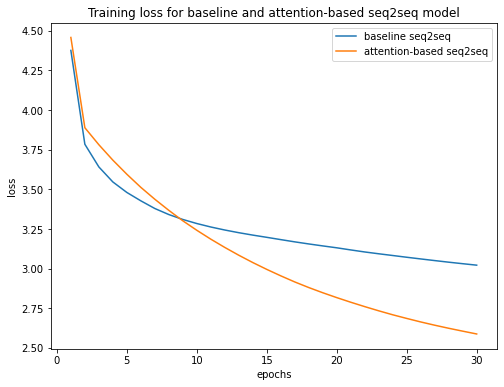

In [ ]:
plt.figure(figsize = (8, 6))
plt.plot(np.arange(1, 31), training_loss_rnn, label = 'baseline seq2seq')
plt.plot(np.arange(1, 31), training_loss_attn, label = 'attention-based seq2seq')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training loss for baseline and attention-based seq2seq model')
plt.legend()
plt.show()

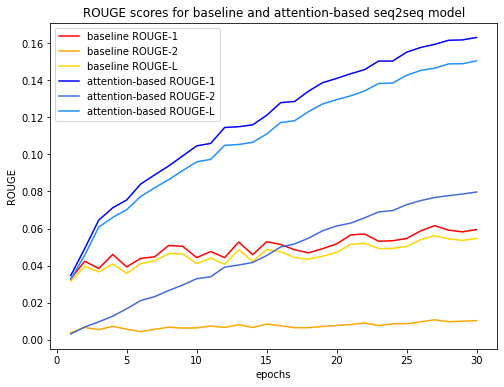

In [ ]:
plt.figure(figsize = (8, 6))
plt.plot(np.arange(1, 31), [x['ROUGE-1'] for x in validation_rouges_rnn], color = 'red', label = 'baseline ROUGE-1')
plt.plot(np.arange(1, 31), [x['ROUGE-2'] for x in validation_rouges_rnn], color = 'orange', label = 'baseline ROUGE-2')
plt.plot(np.arange(1, 31), [x['ROUGE-L'] for x in validation_rouges_rnn], color = 'gold',label = 'baseline ROUGE-L')
plt.plot(np.arange(1, 31), [x['ROUGE-1'] for x in validation_rouges_attn], color = 'blue', label = 'attention-based ROUGE-1')
plt.plot(np.arange(1, 31), [x['ROUGE-2'] for x in validation_rouges_attn], color = 'royalblue', label = 'attention-based ROUGE-2')
plt.plot(np.arange(1, 31), [x['ROUGE-L'] for x in validation_rouges_attn], color = 'dodgerblue', label = 'attention-based ROUGE-L')
plt.xlabel('epochs')
plt.ylabel('ROUGE')
plt.title('ROUGE scores for baseline and attention-based seq2seq model')
plt.legend()
plt.show()

In [ ]:
model_attn = seq2seq(encoder, decoder_attn, id2token, lr = 0.01)

In [ ]:
training_loss, validation_rouges = train_model(train_input, model_attn, 'rnn_seq2seq_encoderattn') 

Epoch: [1/30]



epoch 1 training loss = 4.458343729761694, time = 657.2324318885803
validation rouge: 
{'ROUGE-1': 0.03465730061349693, 'ROUGE-2': 0.003197914110429448, 'ROUGE-L': 0.03261822085889571, 'ROUGE-SU4': 0.007468036809815952}
save new model
Epoch: [2/30]



epoch 2 training loss = 3.888840478871288, time = 655.8434135913849
validation rouge: 
{'ROUGE-1': 0.049236871165644173, 'ROUGE-2': 0.006987791411042944, 'ROUGE-L': 0.04568386503067484, 'ROUGE-SU4': 0.011862208588957054}
save new model
Epoch: [3/30]



epoch 3 training loss = 3.7817617342480876, time = 657.9727981090546
validation rouge: 
{'ROUGE-1': 0.06452055214723926, 'ROUGE-2': 0.00972638036809816, 'ROUGE-L': 0.060777055214723916, 'ROUGE-SU4': 0.016252085889570552}
save new model
Epoch: [4/30]



epoch 4 training loss = 3.684466295136737, time = 658.2113165855408
validation rouge: 
{'ROUGE-1': 0.0711877300613497, 'ROUGE-2': 0.012785521472392638, 'ROUGE-L': 0.06600999999999999, 'ROUGE-SU4': 0.01840993865030675}
save new model
Epoch: [5/30]



epoch 5 training loss = 3.595600452663567, time = 651.4353244304657
validation rouge: 
{'ROUGE-1': 0.0754182208588957, 'ROUGE-2': 0.016803006134969326, 'ROUGE-L': 0.07018815950920246, 'ROUGE-SU4': 0.020511901840490798}
save new model
Epoch: [6/30]



epoch 6 training loss = 3.512799466814649, time = 650.4467225074768
validation rouge: 
{'ROUGE-1': 0.0840080981595092, 'ROUGE-2': 0.021204785276073623, 'ROUGE-L': 0.07728263803680982, 'ROUGE-SU4': 0.023846625766871167}
save new model
Epoch: [7/30]



epoch 7 training loss = 3.4377688137221014, time = 648.6042506694794
validation rouge: 
{'ROUGE-1': 0.08893674846625767, 'ROUGE-2': 0.023317852760736196, 'ROUGE-L': 0.08198435582822086, 'ROUGE-SU4': 0.0256359509202454}
save new model
Epoch: [8/30]



epoch 8 training loss = 3.367751912583871, time = 646.4797759056091
validation rouge: 
{'ROUGE-1': 0.09372969325153375, 'ROUGE-2': 0.02661251533742331, 'ROUGE-L': 0.0863438036809816, 'ROUGE-SU4': 0.02761288343558282}
save new model
Epoch: [9/30]



epoch 9 training loss = 3.301828618712384, time = 645.0975379943848
validation rouge: 
{'ROUGE-1': 0.09913766871165647, 'ROUGE-2': 0.029586319018404913, 'ROUGE-L': 0.09125570552147239, 'ROUGE-SU4': 0.029744049079754607}
save new model
Epoch: [10/30]



epoch 10 training loss = 3.2420426146717234, time = 650.2160317897797
validation rouge: 
{'ROUGE-1': 0.10456711656441718, 'ROUGE-2': 0.03296368098159509, 'ROUGE-L': 0.09596404907975459, 'ROUGE-SU4': 0.0321417791411043}
save new model
Epoch: [11/30]



epoch 11 training loss = 3.185994137990372, time = 646.6306464672089
validation rouge: 
{'ROUGE-1': 0.10588288343558282, 'ROUGE-2': 0.03401748466257669, 'ROUGE-L': 0.09728055214723925, 'ROUGE-SU4': 0.032471165644171775}
save new model
Epoch: [12/30]



epoch 12 training loss = 3.133790782750166, time = 642.7390284538269
validation rouge: 
{'ROUGE-1': 0.11447828220858897, 'ROUGE-2': 0.03923355828220859, 'ROUGE-L': 0.10484386503067486, 'ROUGE-SU4': 0.03630711656441718}
save new model
Epoch: [13/30]



epoch 13 training loss = 3.0846197618329656, time = 641.4537382125854
validation rouge: 
{'ROUGE-1': 0.11487484662576689, 'ROUGE-2': 0.04035196319018405, 'ROUGE-L': 0.10529374233128835, 'ROUGE-SU4': 0.036858957055214726}
save new model
Epoch: [14/30]



epoch 14 training loss = 3.0384770030611703, time = 637.7218005657196
validation rouge: 
{'ROUGE-1': 0.11588883435582821, 'ROUGE-2': 0.04172484662576687, 'ROUGE-L': 0.10646098159509203, 'ROUGE-SU4': 0.037500245398773}
save new model
Epoch: [15/30]



epoch 15 training loss = 2.9953255107921866, time = 633.8789038658142
validation rouge: 
{'ROUGE-1': 0.12101570552147241, 'ROUGE-2': 0.04545030674846626, 'ROUGE-L': 0.11097435582822085, 'ROUGE-SU4': 0.040214539877300615}
save new model
Epoch: [16/30]



epoch 16 training loss = 2.954642544226746, time = 633.6293473243713
validation rouge: 
{'ROUGE-1': 0.12784503067484662, 'ROUGE-2': 0.0501059509202454, 'ROUGE-L': 0.1171278527607362, 'ROUGE-SU4': 0.043757546012269936}
save new model
Epoch: [17/30]



epoch 17 training loss = 2.916127012517913, time = 644.3659191131592
validation rouge: 
{'ROUGE-1': 0.12849, 'ROUGE-2': 0.051706932515337416, 'ROUGE-L': 0.1181122699386503, 'ROUGE-SU4': 0.04419644171779141}
save new model
Epoch: [18/30]



epoch 18 training loss = 2.8807845001291086, time = 656.0267941951752
validation rouge: 
{'ROUGE-1': 0.13407220858895708, 'ROUGE-2': 0.054843558282208583, 'ROUGE-L': 0.12303533742331287, 'ROUGE-SU4': 0.04720680981595092}
save new model
Epoch: [19/30]



epoch 19 training loss = 2.848017830103819, time = 657.7003235816956
validation rouge: 
{'ROUGE-1': 0.1386189570552147, 'ROUGE-2': 0.05882092024539877, 'ROUGE-L': 0.1271684662576687, 'ROUGE-SU4': 0.049504417177914116}
save new model
Epoch: [20/30]



epoch 20 training loss = 2.8172964337127233, time = 652.792952299118
validation rouge: 
{'ROUGE-1': 0.1408784662576687, 'ROUGE-2': 0.06139006134969325, 'ROUGE-L': 0.12944055214723926, 'ROUGE-SU4': 0.05111276073619631}
save new model
Epoch: [21/30]



epoch 21 training loss = 2.7881591111824813, time = 646.9212460517883
validation rouge: 
{'ROUGE-1': 0.14341625766871166, 'ROUGE-2': 0.06292073619631902, 'ROUGE-L': 0.13149828220858895, 'ROUGE-SU4': 0.052446073619631904}
save new model
Epoch: [22/30]



epoch 22 training loss = 2.7604659596345815, time = 649.7110278606415
validation rouge: 
{'ROUGE-1': 0.14563736196319016, 'ROUGE-2': 0.06579300613496933, 'ROUGE-L': 0.1341453374233129, 'ROUGE-SU4': 0.05401613496932515}
save new model
Epoch: [23/30]



epoch 23 training loss = 2.734012721942653, time = 638.9631500244141
validation rouge: 
{'ROUGE-1': 0.1502534355828221, 'ROUGE-2': 0.06892680981595092, 'ROUGE-L': 0.13816981595092026, 'ROUGE-SU4': 0.05669368098159509}
save new model
Epoch: [24/30]



epoch 24 training loss = 2.7089608772801004, time = 634.8066883087158
validation rouge: 
{'ROUGE-1': 0.1502336809815951, 'ROUGE-2': 0.0697001226993865, 'ROUGE-L': 0.13840638036809816, 'ROUGE-SU4': 0.056786687116564406}
Epoch: [25/30]



epoch 25 training loss = 2.6859489623617567, time = 623.1356394290924
validation rouge: 
{'ROUGE-1': 0.1550249079754601, 'ROUGE-2': 0.07284263803680982, 'ROUGE-L': 0.14258515337423314, 'ROUGE-SU4': 0.05936116564417178}
save new model
Epoch: [26/30]



epoch 26 training loss = 2.663798076786825, time = 629.3733019828796
validation rouge: 
{'ROUGE-1': 0.15757233128834355, 'ROUGE-2': 0.07505907975460122, 'ROUGE-L': 0.1451963190184049, 'ROUGE-SU4': 0.06108993865030675}
save new model
Epoch: [27/30]



epoch 27 training loss = 2.6432397205744578, time = 636.4549434185028
validation rouge: 
{'ROUGE-1': 0.15924018404907975, 'ROUGE-2': 0.07672705521472392, 'ROUGE-L': 0.14640570552147242, 'ROUGE-SU4': 0.062192147239263806}
save new model
Epoch: [28/30]



epoch 28 training loss = 2.6239058483130817, time = 634.5589489936829
validation rouge: 
{'ROUGE-1': 0.1614487116564417, 'ROUGE-2': 0.07772779141104295, 'ROUGE-L': 0.14871932515337424, 'ROUGE-SU4': 0.06320650306748465}
save new model
Epoch: [29/30]



epoch 29 training loss = 2.6056944774085746, time = 634.4191212654114
validation rouge: 
{'ROUGE-1': 0.16166018404907975, 'ROUGE-2': 0.07860883435582822, 'ROUGE-L': 0.14883662576687115, 'ROUGE-SU4': 0.06393613496932514}
save new model
Epoch: [30/30]



epoch 30 training loss = 2.5879163629161184, time = 634.8247797489166
validation rouge: 
{'ROUGE-1': 0.16296809815950922, 'ROUGE-2': 0.07968699386503066, 'ROUGE-L': 0.15034613496932514, 'ROUGE-SU4': 0.06443386503067484}
save new model


In [ ]:
torch.save(training_loss, os.path.join(result_dir, 'seq2seq_encoderattn_trainloss.pt'))
torch.save(validation_rouges, os.path.join(result_dir, 'seq2seq_encoderattn_valrouge.pt'))

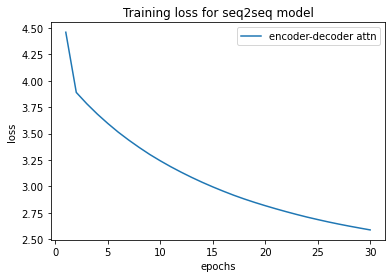

In [ ]:
plt.plot(np.arange(1, 31), training_loss, label = 'encoder-decoder attn')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training loss for seq2seq model')
plt.legend()
plt.show()

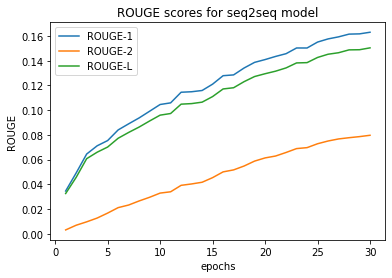

In [ ]:
plt.plot(np.arange(1, 31), [x['ROUGE-1'] for x in validation_rouges], label = 'ROUGE-1')
plt.plot(np.arange(1, 31), [x['ROUGE-2'] for x in validation_rouges], label = 'ROUGE-2')
plt.plot(np.arange(1, 31), [x['ROUGE-L'] for x in validation_rouges], label = 'ROUGE-L')
plt.xlabel('epochs')
plt.ylabel('ROUGE')
plt.title('ROUGE scores for seq2seq model')
plt.legend()
plt.show()

In [ ]:
model = torch.load(os.path.join(model_dir, 'rnn_seq2seq_encoderattn'))

In [ ]:
def showAttention(text, summary, attentions):

    fig = plt.figure(figsize = (20, 5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap = 'Blues', aspect = 'auto')
    fig.colorbar(cax)
    ax.set_xticklabels(text, rotation = 90)
    ax.set_yticklabels(summary)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

In [ ]:
def get_summary(model, text):

    print('text: ', text)
    # tokenized_text = jieba.cut(text, use_paddle = True)
    # tokenized_text = [word for word in tokenized_text]
    # print('tokenized text: ', tokenized_text)
    # tokenized_text_idx = token2index([tokenized_text])
    # batch = [torch.tensor(tokenized_text_idx), torch.tensor([len(tokenized_text_idx[0])])]
    tokenized_text_idx = token2index([[word for word in text]])
    batch = [torch.tensor(tokenized_text_idx), torch.tensor([len(tokenized_text_idx[0])])]

    summary, attn_scores_list = model.eval_step(batch, return_attn = True)
    summary = summary[0]
    summary = [id2token[idx] for idx in summary]
    print('predicted summary: ', ''.join(summary))
    

    # summary_beam = model.eval_step_beam_search(batch)
    # summary_beam = summary_beam[0]
    # summary_beam = [''.join([id2token[idx.item()] for idx in beam]) for beam in summary_beam]

    # print('predicted summary (beam search size = {}): '.format(len(summary_beam)), summary_beam)

    # if attn_scores_list[0] is not None:
    #     if attn_scores_list[0][0] is not None:
    #         print('Encoder decocder attention:')
    #         attn_matrix = [x[0].data.cpu().numpy() for x in attn_scores_list]
    #         attn_matrix = np.stack(attn_matrix)[:, :, 0]
    #         showAttention([word for word in text], summary, attn_matrix)

In [ ]:
idx = 900
get_summary(model, ''.join(train_text[idx]))
print(''.join(train_summary[idx]))

text:  游客走出国门企业投资海外作为世界第二大经济体中国在海外的存在感不断加强为了更好地维护公民和法人在海外的正当权益中国将不断加强涉外法律工作以构筑更加完善的法律保护网
predicted summary:  <SOS>海外法律保护网<EOS>
中国将完善涉外法律保护公民海外权益
